# Pop-Contour Stochastic Gradient Langevin Dynamics 

## Preliminaries

In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import log, sqrt, sin, cos, exp, pi, prod
from autograd.numpy.random import normal, uniform
import time
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import imageio
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

In [2]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.random.seed(75)

Build a non-convex energy function

In [3]:
def mixture(x):
    energy = ((x[0]**2 + x[1]**2)/10 - (cos(2.0*pi*x[0]) + cos(2.0*pi*x[1]))) / 0.5 # 2
    regularizer = ((x[0]**2 + x[1]**2) > 20) * ((x[0]**2 + x[1]**2) - 20)
    return energy + regularizer

def mixture_expand(x, y): return mixture([x, y])
def function_plot(x, y): return np.exp(-mixture([x, y]))

lower, upper = -2.5, 2.5
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
axis_X, axis_Y = np.meshgrid(axis_x, axis_y)

energy_grid = mixture_expand(axis_X, axis_Y)
prob_grid = function_plot(axis_X, axis_Y)

Establish the upper and lower bound for the partions.

In [4]:
lower_bound, upper_bound = np.min(energy_grid) - 1, np.max(energy_grid) + 1

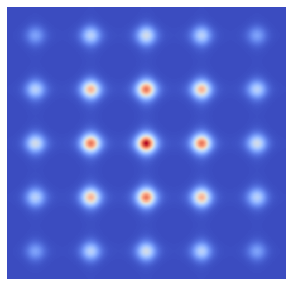

In [5]:
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/'
fig = plt.figure(figsize=(5, 5))
# plt.subplot(1, 1, 1).set_title('Target distribution')
sns.heatmap(prob_grid, cmap=cm.coolwarm, cbar=False, xticklabels=False, yticklabels=False).invert_yaxis()
plt.savefig(PATH+"heat_map.png")

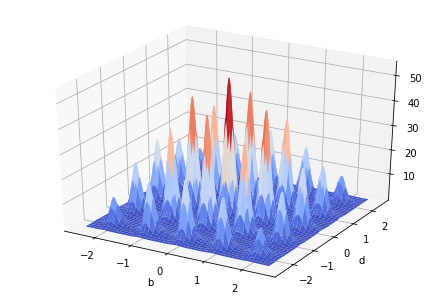

In [ ]:
axis_x = np.linspace(lower, upper, 500)
axis_y = np.linspace(lower, upper, 500)
B, D = np.meshgrid(axis_x, axis_y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(B, D, prob_grid, cmap=cm.coolwarm)
plt.xlabel('b')
plt.ylabel('d')
plt.savefig(PATH + '3-d.png')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


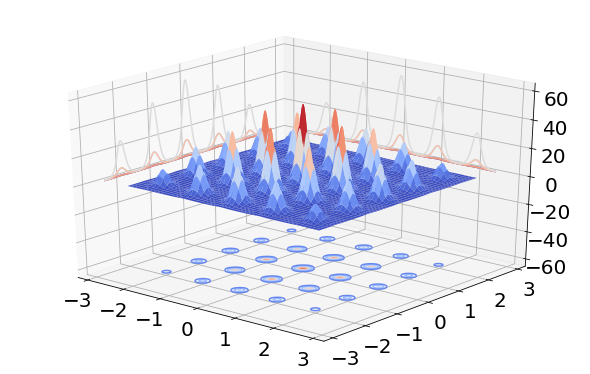

In [ ]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 23,
}

font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30,
}


PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/'
fig = plt.figure(figsize=(8, 5))
ax = Axes3D(fig)
ax.plot_surface(B, D, prob_grid, cmap=cm.coolwarm)
cset = ax.contour(B, D, prob_grid, zdir='z', offset=-20*pi, cmap=cm.coolwarm) 
cset = ax.contour(B, D, prob_grid, zdir='x', offset=-pi, cmap=cm.coolwarm) 
cset = ax.contour(B, D, prob_grid, zdir='y', offset=pi, cmap=cm.coolwarm)

plt.tick_params(labelsize=20)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.subplots_adjust(left = 0.15,bottom=0.128)
ax.view_init(elev=25,azim=-50)

ax.set_xlim3d(-pi, pi); 
ax.set_ylim3d(-pi, pi); 
ax.set_zlim3d(-20*pi, 20*pi);
plt.savefig(PATH+"target_dist.png")

# Build Parallel Sampler

In [6]:
class PSampler:
    def __init__(self, f=None, dim=None, boundary=None, xinit=None, \
                 partition=None, lr=0.1, zeta=1.0, T=1.0, decay_lr=100., parts=100, theta_init = []):
        self.N = len(xinit) # number of parallel markov chain
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
        self.decay_lr = decay_lr
        self.parts = parts
        self.zeta = zeta
        
        
        self.partition = partition # [energy lower bound, energy upper bound] -- U(x)
        self.boundary = boundary # Domain boundary of X
        
        # initialization for ICSGLD
        self.x = np.array(xinit)
        if not theta_init:
            self.Gcum = np.array(range(self.parts, 0, -1)) * 1.0 / sum(range(self.parts, 0, -1))
        else:
            self.Gcum = theta_init
        self.div_f = (self.partition[1] - self.partition[0]) / self.parts
        self.J = [self.parts - 1] * self.N

    
    def in_domain(self, beta): 
        return sum(map(lambda i: beta[i] < self.boundary[0] or beta[i] > self.boundary[1], range(self.dim))) == 0

    def stochastic_grad(self, beta):  return grad(self.f)(beta) + 0.25*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.25*normal(size=1)

    # find the partition index J
    def find_idx(self, beta): 
        return min(max(int((self.stochastic_f(beta) - self.partition[0]) / self.div_f + 1), 1), self.parts - 1)
    
    def icsgld_step(self, iters):        
        self.grad_mul = [1 + self.zeta * self.T * (np.log(self.Gcum[self.J[i]]) 
        - np.log(self.Gcum[self.J[i]-1])) / self.div_f for i in range(self.N)]
        
        proposal = [self.x[i] - self.lr * self.grad_mul[i] * self.stochastic_grad(self.x[i]) 
        + sqrt(2. * self.lr * self.T) * normal(size=self.dim) for i in range(self.N)]
        
        for i in range(self.N):
            if self.in_domain(proposal[i]):
                self.x[i] = proposal[i]
            self.J[i] = self.find_idx(self.x[i])
        
        step_size = min(self.decay_lr, 1./(iters**0.6+100))
        
        for i in range(self.parts):
            tmp = 0
            for j in range(self.N):
                if i == self.J[j]:
                    tmp += self.Gcum[self.J[j]] * (1-self.Gcum[i])
                else:
                    tmp += self.Gcum[self.J[j]] * (-self.Gcum[i])  

            self.Gcum[i] = self.Gcum[i] + step_size * tmp / self.N


## Simulate from a flat density and record the importance weights in parallel

###find a good initialization using SGLD

In [7]:
class SGLDSampler:
    def __init__(self, f=None, dim=None, xinit=None, lr=0.1, T=1.0, decay_lr=100.):
        self.f = f
        self.dim = dim
        self.lr = lr
        self.T = T
        self.decay_lr = decay_lr
      
         
        # initialization for SGLD
        self.x = np.array(xinit)
        

    def stochastic_grad(self, beta):  return grad(self.f)(beta) + 0.25*normal(size=self.dim)

    def stochastic_f(self, beta): return self.f(beta.tolist()) + 0.25*normal(size=1)

    def sgld_step(self, iters):  
        self.x = self.x - self.lr * self.stochastic_grad(self.x) + sqrt(2. * self.lr * self.T) * normal(size=self.dim) 

In [8]:
sampler = SGLDSampler(f=mixture, dim=2, xinit=[0.,0.], lr=3e-3, T=1, decay_lr=3e-3)
warm_up = 5000
sgld_x = np.array([sampler.x])

In [9]:
for iters in range(int(2e4)):
    sampler.sgld_step(iters)
    if iters > warm_up:
        if iters % 20 == 0:
            sgld_x = np.vstack((sgld_x, sampler.x))

In [ ]:
# obtain an estimate of theta
# find the partition index J

def stochastic_f(beta, f): return f(beta.tolist()) + 0.25*normal(size=1)

def find_idx(beta, partition, parts, f): 
    div_f = (partition[1] - partition[0]) / parts
    return min(max(int((stochastic_f(beta, f) - partition[0]) / div_f + 1), 1), parts - 1)

theta = [0] * 100
for i in range(len(sgld_x)):
    idx = find_idx(sgld_x[i], [lower_bound, upper_bound], 100, mixture)
    theta[idx] += 1
theta = list(np.array(theta) / sum(theta) + 0.0001)
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/ICSGLD_result/'
import pickle
f = open(PATH+'initialization.txt', 'wb')
pickle.dump(theta, f)
f.close()

build a sampler

In [10]:
zeta = 0.75
import pickle
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/ICSGLD_result/'
f = open(PATH + 'initialization.txt', 'rb')
theta = pickle.load(f)
f.close()
psampler = PSampler(f=mixture, dim=2, boundary=[lower, upper], xinit=[[0.,-1.],[0.,0.],[-1.,0.],[0.,1.],[1.,0.]], \
                  partition=[lower_bound, upper_bound], zeta = zeta, lr=3e-3, T=1, decay_lr=3e-3, parts=100, theta_init=theta)

warm_up = 1000
N = 5
icsgld_x = np.array(psampler.x)
importance_weights = [[0.] * N]

###Compute the exact energy *PDF*

In [11]:
exact_energy_pdf = []
energy_unit = (upper_bound - lower_bound) * 1.0 / psampler.parts
exact_energy_grids = lower_bound + np.arange(psampler.parts) * energy_unit

fine_axis_x = np.linspace(lower, upper, 500)
fine_axis_y = np.linspace(lower, upper, 500)
fine_axis_X, fine_axis_Y = np.meshgrid(fine_axis_x, fine_axis_y)

fine_energy_grid = mixture_expand(fine_axis_X, fine_axis_Y)
fine_prob_grid = function_plot(fine_axis_X, fine_axis_Y)
fine_prob_grid /= fine_prob_grid.sum()
for ii in range(psampler.parts):
    tag = (fine_energy_grid > lower_bound + ii * energy_unit) & (fine_energy_grid < lower_bound + (ii + 1) * energy_unit)
    exact_energy_pdf.append(fine_prob_grid[tag].sum())


In [ ]:
my_images3, my_images4 = [], []
history_samples = np.zeros(shape=(0,80))
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/ICSGLD_result/'
if not os.path.isdir(PATH):
    try:
        os.makedirs(PATH)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(PATH):
            pass
        else:
            raise

time_path = []
for iters in range(int(8e4)):
    psampler.icsgld_step(iters)
    if iters > warm_up:
        if iters % 20 == 0:
            icsgld_x = np.vstack((icsgld_x, psampler.x))
            time_path.append(time.clock())
            importance_weights.append([psampler.Gcum[psampler.J[i]]**zeta for i in range(N)])

        if iters % 1000 == 0 and len(icsgld_x[:,1]) > 5:
            # fig3=plt.figure(figsize=(4,4.2), frameon=False)
            # plt.cla()  
            # #plt.subplot(1, 2, 1).set_title('Contour SGLD', fontsize=18)
            # plt.contour(axis_X, axis_Y, prob_grid)
            # plt.plot(csgld_x[:,0][:-4], csgld_x[:,1][:-4], linewidth=0.1, marker='.', markersize=2, alpha=0.1, color='k', label="Iter="+str(iters))
            # col_type = 0 if psampler.grad_mul > 0 else 1
            # plt.plot(csgld_x[:,0][-3], csgld_x[:,1][-3], linewidth=0.3, marker='.', markersize=5, color=jump_col[col_type], alpha=1, label="Bounces="+str(sampler.bouncy_move))
            # plt.plot(csgld_x[:,0][-2], csgld_x[:,1][-2], linewidth=0.3, marker='.', markersize=7, color=jump_col[col_type], alpha=1)
            # for i in range(psampler.N):
            #   if psampler.Gcum[psampler.J[i]]**psampler.zeta < 1e-4:
            #       plt.plot(csgld_x[:,0][-1], csgld_x[:,1][-1], linewidth=0.3, marker='.', markersize=10, color=jump_col[col_type], alpha=1)
            #   else:
            #       plt.plot(csgld_x[:,0][-1], csgld_x[:,1][-1], linewidth=0.3, marker='.', markersize=13, color=jump_col[col_type], alpha=1)
            #   plt.legend(loc="upper left", prop={'size': 11})
            #   plt.gca().axes.xaxis.set_visible(False)
            #   plt.gca().axes.yaxis.set_visible(False)
            #   plt.xlim([-boundary_, boundary_])
            #   plt.ylim([-boundary_, boundary_])
            #   #plt.xticks(fontsize=13)
            #   #plt.yticks(fontsize=13)
            #   #plt.xlabel(r"$X_1$", fontsize=13)
            #   #plt.ylabel(r"$X_2$", fontsize=13)
            #   plt.title('Contour SGLD', fontsize=22)
            #   plt.tight_layout()
            #   plt.show()
            # fig3.canvas.draw()       # draw the canvas, cache the renderer
            # image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
            # my_images3.append(image3)
            
            # #print(sampler.grad_mul)
            # #print(upper_bound, sampler.stochastic_f(sampler.csgld_beta))
            
            
            
            history_samples = np.vstack((history_samples, psampler.Gcum[:80]))
            col_std = np.std(history_samples, 0) / sqrt(history_samples.shape[0])
            
            #plt.subplot(1, 2, 2).set_title('Energy PDF estimate', fontsize=18)
            fig4=plt.figure(figsize=(4,4.2), frameon=False)
            plt.cla()  
            #plt.rcParams['legend.title_fontsize'] = 'small'
            plt.plot(psampler.Gcum[:80], color='red', label="Estimation", linewidth=1.5)
            plt.plot(exact_energy_pdf[:80], color='black', label="Ground truth", linewidth=1.5)
            plt.legend(loc="upper right", prop={'size': 13})
            plt.ylim([0, 0.07])
            plt.gca().axes.xaxis.set_visible(False)
            plt.gca().axes.yaxis.set_visible(False)
            #plt.xticks([0, 15, 30, 45, 60], np.round((map(exact_energy_grids.__getitem__, [0, 15, 30, 45, 60])), 1), fontsize=13)
            #plt.yticks([0, 0.04, 0.08, 0.12], fontsize=18)
            #plt.xlabel("Energy", fontsize=13)
            #plt.ylabel("Energy PDF", fontsize=13)
            plt.annotate("Higher energy", fontsize=14, xy=(55, 0.005), xytext=(25, 0.03), arrowprops=dict(arrowstyle="->"))
            plt.title('Energy PDF estimate', fontsize=22)
            plt.fill_between(range(80), psampler.Gcum[:80]-15*col_std, psampler.Gcum[:80]+15*col_std, color='red', alpha=.3)

            plt.tight_layout()
            plt.show()
            fig4.canvas.draw()       # draw the canvas, cache the renderer
            image4 = np.frombuffer(fig4.canvas.tostring_rgb(), dtype='uint8').reshape(fig4.canvas.get_width_height()[::-1] + (3,))
            my_images4.append(image4)

        if iters % 1000 == 0:
            fig3 = plt.figure(figsize=(4, 4))
            plt.contour(axis_X, axis_Y, prob_grid, 10)
            plt.yticks([-4, -2, 0, 2, 4]) 
            plt.scatter(icsgld_x[:,0], icsgld_x[:,1], marker='.', s=3, color='k', label="Iteration="+str(iters)) 
            plt.legend(loc="upper left", prop={'size': 10})
            plt.xlim([lower, upper])
            plt.ylim([lower, upper])
            plt.tight_layout()
            # plt.show()
            fig3.canvas.draw()
            image3 = np.frombuffer(fig3.canvas.tostring_rgb(), dtype='uint8').reshape(fig3.canvas.get_width_height()[::-1] + (3,))
            my_images3.append(image3)

imageio.mimsave('anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/result/ICSGLD_contour_'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images3, fps=50)      
imageio.mimsave('anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/result/ICSGLD_PDF'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.gif', my_images4, fps=50)

# save the sampels
import pickle
f = open(PATH + 'ICSGLD_samples'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.txt', 'wb')
pickle.dump(icsgld_x, f)
f.close()  
f = open(PATH + 'ICSGLD_importance weight'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.txt', 'wb')
pickle.dump(importance_weights, f)
f.close()  

Output hidden; open in https://colab.research.google.com to view.

# Resampling via importance weights

In [ ]:
import pickle
PATH = 'anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/ICSGLD_result/'
f = open(PATH + 'ICSGLD_samples'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.txt', 'rb')
icsgld_x = pickle.load(f)
f.close()
f = open(PATH + 'ICSGLD_importance weight'+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+'.txt', 'rb')
importance_weights = pickle.load(f)
f.close()
scaled_importance_weights = np.array(importance_weights) / np.mean(np.array(importance_weights), axis=0)
scaled_importance_weights = scaled_importance_weights.reshape((-1,1))

resample_x = np.empty((0,2))
for i in range(len(icsgld_x)):
    while scaled_importance_weights[i] > 1:
        tag = np.random.binomial(1, p=min(1, scaled_importance_weights[i]))
        scaled_importance_weights[i] -= 1
        if tag == 1:
            resample_x = np.vstack((resample_x, icsgld_x[i,]))
    if scaled_importance_weights[i] > np.random.uniform(0, 1):
        resample_x = np.vstack((resample_x, icsgld_x[i,]))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: Fu

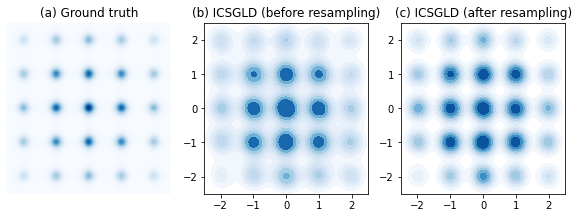

In [ ]:
fig = plt.figure(figsize=(10, 3.15))
plt.subplot(1, 3, 1).set_title('(a) Ground truth')
sns.heatmap(prob_grid, cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)

warm_sample = 0
split_ = 1
plt.subplot(1, 3, 2).set_title('(b) ICSGLD (before resampling)')
ax = sns.kdeplot(icsgld_x[:,0][::split_][warm_sample:], icsgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

plt.subplot(1, 3, 3).set_title('(c) ICSGLD (after resampling)')
ax = sns.kdeplot(resample_x[:,0][::split_][warm_sample:], resample_x[:,1][::split_][warm_sample:], cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

plt.savefig("anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/ICSGLD_result/population_"+str(zeta)+"_"+str(psampler.lr)+"_"+str(psampler.T)+".png")

In [ ]:
fig = plt.figure(figsize=(3.15, 3.15))

warm_sample = 0
split_ = 1
ax = sns.kdeplot(icsgld_x[:,0][::split_][warm_sample:], icsgld_x[:,1][::split_][warm_sample:],  cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)

plt.savefig("anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/ICSGLD_before.png")
plt.close()

fig = plt.figure(figsize=(3.15, 3.15))
ax = sns.kdeplot(resample_x[:,0][::split_][warm_sample:], resample_x[:,1][::split_][warm_sample:], cmap="Blues", shade=True, thresh=0.05, bw=0.15)
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
plt.savefig("anonymous/Contour-Stochastic-Gradient-Langevin-Dynamics/simulation_figures/ICSGLD_after.png")
plt.close()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1657: Fu